In [1]:
!pip install streamlit

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [3]:
#Load the Receipe data
recipes_df = pd.read_csv('/Recommendation_foods/food/RAW_recipes.csv')

#Extract key recipe features
recipe_data = recipes_df[['id', 'name', 'ingredients', 'minutes', 'tags']]

#Clean up the ingredients column
recipe_data['ingredients'] = recipe_data['ingredients'].apply(lambda x: x.split(','))

#Preview the cleaned data
recipe_data.head()

C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_22016\3004464232.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipe_data['ingredients'] = recipe_data['ingredients'].apply(lambda x: x.split(','))


,id,name,ingredients,minutes,tags
0,137739,arriba baked winter squash mexican style,"[['winter squash', 'mexican seasoning', 'mix...",55,"['60-minutes-or-less', 'time-to-make', 'course..."
1,31490,a bit different breakfast pizza,"[['prepared pizza crust', 'sausage patty', '...",30,"['30-minutes-or-less', 'time-to-make', 'course..."
2,112140,all in the kitchen chili,"[['ground beef', 'yellow onions', 'diced tom...",130,"['time-to-make', 'course', 'preparation', 'mai..."
3,59389,alouette potatoes,"[['spreadable cheese with garlic and herbs', ...",45,"['60-minutes-or-less', 'time-to-make', 'course..."
4,44061,amish tomato ketchup for canning,"[['tomato juice', 'apple cider vinegar', 'su...",190,"['weeknight', 'time-to-make', 'course', 'main-..."


In [4]:
#Load the interactions data
user_ratings_cleaned = pd.read_csv("/Recommendation_foods/food/RAW_interactions.csv")

#Sample a small fraction of users and recipes for testing 
sampled_users = user_ratings_cleaned['user_id'].sample(frac=0.01, random_state=42).unique()
sampled_recipes = user_ratings_cleaned['recipe_id'].sample(frac=0.01, random_state=42).unique()

#Filter the user ratings DataFrame to include only the sampled users and recipes
user_ratings_sampled = user_ratings_cleaned[user_ratings_cleaned['user_id'].isin(sampled_users) & 
                                            user_ratings_cleaned['recipe_id'].isin(sampled_recipes)]


#Reindex user_id and recipe_id to continuous integers
user_ratings_sampled['user_idx'] = user_ratings_sampled['user_id'].astype('category').cat.codes
user_ratings_sampled['recipe_idx'] = user_ratings_sampled['recipe_id'].astype('category').cat.codes

C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_22016\2177818387.py:2: DtypeWarning: Columns (2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  user_ratings_cleaned = pd.read_csv("/Recommendation_foods/food/RAW_interactions.csv")
C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_22016\2177818387.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_sampled['user_idx'] = user_ratings_sampled['user_id'].astype('category').cat.codes
C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_22016\2177818387.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [5]:
#Check for duplicates
duplicate_entries = user_ratings_sampled[user_ratings_sampled.duplicated(subset=['user_idx', 'recipe_idx'], keep=False)]

#Aggregate duplicate entries by taking the mean rating for each user-recipe pair
user_ratings_aggregated = user_ratings_sampled.groupby(['user_idx', 'recipe_idx']).agg({'rating': 'mean'}).reset_index()

#Keep only the first rating for each user-recipe pair
user_ratings_unique = user_ratings_sampled.drop_duplicates(subset=['user_idx', 'recipe_idx'], keep='first')

In [6]:
#Preview the data
user_ratings_unique.head()

,user_id,recipe_id,date,rating,review,user_idx,recipe_idx
60,49304.0,180132.0,13/02/2007,5.0,Delicious easy to make soup which we really en...,233,2331
77,58439.0,180132.0,09/06/2007,4.0,"GREAT hearty chicken soup, TRUE!\r\nDoes make ...",306,2331
78,628951.0,180132.0,13/11/2007,5.0,Very good and tasty especially when your cravi...,1974,2331
428,870928.0,269690.0,28/02/2010,5.0,Loved this! Looking for something easy to cook...,2218,2944
545,58104.0,32129.0,02/12/2002,5.0,Quick and easy!\r\nI also added 1/2 cup of roa...,302,520


In [7]:
#Fill missing values with 0 - indicating no interaction
user_recipe_matrix = user_ratings_aggregated.pivot(index='user_idx', columns='recipe_idx', values='rating').fillna(0)

#Convert the matrix to a sparse format to save memory
user_recipe_sparse = csr_matrix(user_recipe_matrix.values)

#Fit the NearestNeighbors model using the sparse matrix
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_recipe_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [8]:
def recommend_recipes(user_idx, n_recommendations=5):
    #Ensure user_idx is within bounds
    if user_idx >= user_recipe_sparse.shape[0]:
        raise IndexError(f"user_idx {user_idx} is out of bounds for matrix with {user_recipe_sparse.shape[0]} users.")
    
    #Use KNN to find similar users
    distances, indices = model_knn.kneighbors(user_recipe_sparse[user_idx, :].toarray(), n_neighbors=n_recommendations+1)
    
    #Get similar user indices (excluding the user itself)
    similar_users = indices.flatten()[1:]
    
    recommended_recipes = []
    for similar_user in similar_users:
        #Find non-zero recipe indices for similar users
        recipe_indices = user_recipe_sparse[similar_user, :].nonzero()[1]
        recommended_recipes.extend(recipe_indices)
    
    return recommended_recipes

In [9]:
#Test recommendation
try:
    recommended = recommend_recipes(203, n_recommendations=5)
    print(f"Recommended recipes for user 203: {recommended}")
except IndexError as e:
    print(e)

Recommended recipes for user 203: [313, 277, 1637, 165, 277, 430, 433, 1087, 1753, 1961, 2597, 2703, 277, 453, 555, 736, 944, 1115, 1635, 1862, 2235, 2758, 3289, 277, 342, 698, 1239, 1255, 1368, 1463, 1953, 2305, 2490, 2612]


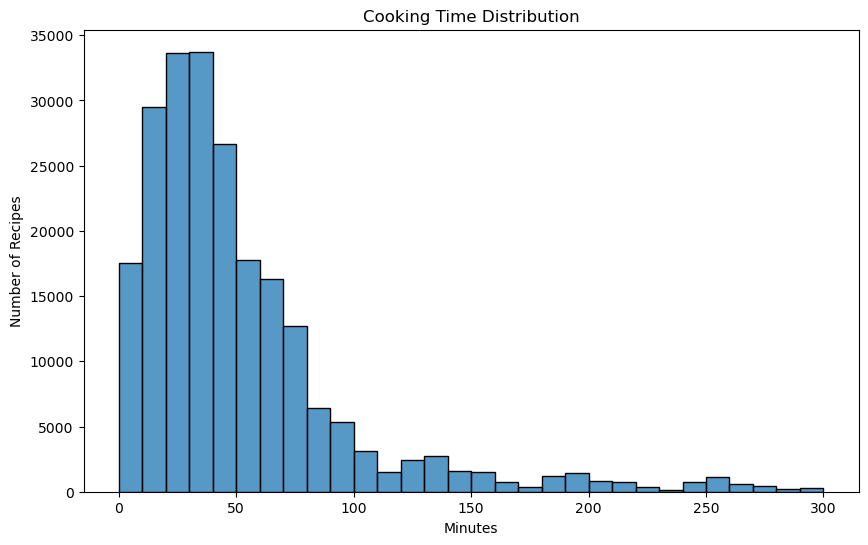

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

#Cap values at 300 minutes (5 hours), for example
capped_recipe_data = recipe_data[recipe_data['minutes'] <= 300]

#Visualize cooking time distribution
plt.figure(figsize=(10, 6))
sns.histplot(capped_recipe_data['minutes'], bins=30)
plt.title("Cooking Time Distribution")
plt.xlabel("Minutes")
plt.ylabel("Number of Recipes")
plt.show()